# Simulación de Eventos Discretos - TP1

En este trabajo práctico buscamos modelar el sistema que define el [Product Space](https://atlas.cid.harvard.edu/), tal que se puedan utilizar simulaciones sobre éste que nos permita analizar características de los Product Spaces subyacentes.

Nos interesa particularmente la relación entre el Product Space (y las variables que surgen de sus definiciones) y los indicadores socioeconómicos de los distintos países que forman parte de esta red. Entendemos que **los países quieren progresar y pueden usar (alguna) información del Product Space para tomar decisiones** respecto de políticas públicas, inversiones, oportunidades a corto y largo plazo con el objeto de mejorar en indicadores tales como PBI, PBI per cápita, GINI, formalidad laboral, etc. Existen (y fueron demostradas) correlaciones significativas entre estos indicadores y variables del Product Space como el Economic Complexity Index (ECI) o el Relative Competitive Advantage (RCA), por lo que se puede generar un paralelismo razonable entre “avanzar” en el Product Space y mejorar la economía y sociedad de un país.

Asignaremos **estrategias de crecimiento** a cada país y ajustaremos los parámetros de las mismas en función de datos reales de la economía de cada uno de ellos. Luego **a través de un Mercado internacional determinados Productos serán demandados a los países**, dado que los recursos productivos son finitos, determinados y dispares el Mercado deberá distribuir las demandas respetando esta disparidad, que también se puede observar en el Product Space.

En concreto, el problema que estamos tratando de resolver se basa en una situación real -el intercambio de bienes entre países y sus trayectorias socioeconómicas- pero que trataremos de forma idealizada. A partir de esta modelización, trataremos de responder las siguientes preguntas: ¿cómo se modifica la descripción en el Product Space de los países según sus distintas estrategias?¿Después de cierto tiempo, se alcanzan valores estables y comunes para indicadores socioeconómicos como el índice de GINI?¿Cómo evoluciona la desigualdad cuando la demanda de productos fluctúa altamente?¿Cómo impacta en la desigualdad y en los productos exportados el hecho de que la priorización de nuevos productos se base únicamente en el RCA (Relative Competitive Advantage)?¿Cómo se comparan las estrategias evaluadas con la selección aleatoria de nuevos productos? (Estrategia random de crecimiento)

Por restricciones temporales y de conocimiento no llegamos a incluir en el modelo y posterior analisis a todas estas preguntas. En particular, no logramos incluir indicadores de bienestar socioeconómico (por ejemplo, GINI).

Conseguimos implementar dos estrategias de crecimiento distintas: una más conservadora, que decide seguis exportando los productos conocidos por el pais, y una más arriesgada que busca diversificar. Esta última va a producir productos que le son más similares a su cartera de productos actual.

Tenemos tres tipos de componentes: el mercado, los productos y los paises. Cada año, se generarán pedidos de productos para los paises y estos decidirán si cumplen con estas demandas. En la simulación, un año equivale a una hora de tiempo virtual.

La dinámica de los productos es la de crecimiento lineal ajustado por una regresión a [datos reales](https://atlas.cid.harvard.edu/data-downloads). Estos determinan la demanda que se realizará de cada producto para ese año.

El mercado recibe la demanda de cada producto y decide como dividirla entre los distintos paises. Para cada producto, el 80% de la demanda es dividida entre los paises que ya lo producían el año anterior respetando la proporción de cúanto producían (sostén de la producción), un 10% se divide entre cinco paises que no lo exportaban (de forma aleatoria), y el restante 10% se distribuye entre los países que producían los productos pero asignado de forma equitativa (aumento de la producción).

El mercado le ofrece demanda a los países de forma secuencial: si el primer país no cumple con una demanda para un producto, esta se distribuirá (equitativamente) entre todos los paises a los cuales se decidió demandarle para este año.

Cada país recibirá una tupla con las demandas que le corresponden de cada producto. Cada país cuenta con una medida de su PBI, que inicia con datos reales y crece en la misma proporción que sus exportaciones. Al recibir demandas, podrá utilizar alguna estrategia para asignar su presupuesto de reinversión (el cual determinamos como 1% del PBI) para aumentar su producción en algún producto o producir nuevos.

Diremos que el costo de producción por dolar no previamente exportado (incremento) de producto es: $costo_p = \frac{1}{2} \cdot 10^{(1 - proximidad_{p,c})}$ donde $p$ es el producto, $c$ el pais y $proximidad$ es la distancia entre $p$ y los productos producidos por el país $c$ el el Espacio de Productos, o 1 si $p$ ya es exportado por $c$.

Los países tienen implementada una estrategia conservadora, la cual usaremos en los próximos análisis. Esta estrategia divide el presupuesto entre los productos que ya fueron producidos por el pais durante el año anterior y cuya demanda aumentó, de forma equitativa con respecto al extra demandado.

El modelo fue pensado de forma extensible: pueden agregarse nuevas estrategias, indicadores socioeconómicos y otros comportamientos de forma simple y bien modularizada requiriendo cambios solamente en componentes particulares.

## Simulación Modelo Estrategia Conservadora

Como primer paso, corremos un script que genera el archivo .ma con los datos reales de paises y productos.

In [ ]:
%%bash

cd model

python3 generate_ma.py

Corremos el modelo durante 20 años:

In [ ]:
%%bash

mkdir -p logs
src/bin/cd++ -m model/simulationConservative.ma \
             -t 20:00:00:000 \
             -l logs/simulation.log \
             -o simulation.out

Cargamos los datos de salida de la simulación:

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# definimos los path a los archivos de interés
OUT_FILENAME = "simulation.out"

# definimos los nombres de las columnas en los dataframes de pandas
TIME_COL = 'time'
PORT_COL = 'port'
VALUE_COL = 'value'
# MESSAGE_TYPE_COL = 'message_type'
# MODEL_ORIGIN_COL = 'model_origin'
# MODEL_DEST_COL = 'model_dest'

# parsea cada fila del dataframe
def parse_value(value: str):
    if '?' in value: return None
    is_list = value.strip().startswith("[") and value.strip().endswith("]")
    if is_list:
        return tuple(float(num) for num in value.replace('[', '').replace(']', '').split(', '))
    return float(value)

# conversion VTime a float
def time_to_years(time):
    h, m, s, ms, r = time.split(':')
    return h

df_converters = {
    VALUE_COL: parse_value,
    TIME_COL: time_to_years
}

salida = pd.read_csv(OUT_FILENAME,
                     delimiter=r'(?<!,)\s+',
                     engine='python',  # C engine doesnt work for regex
                     converters=df_converters,
                     names=[TIME_COL, PORT_COL, VALUE_COL]
                    )

# veamos cómo luce el dataframe con los datos de salida
salida[[f'demand_c{0}' == port for port in salida[PORT_COL]]][VALUE_COL].head() # filtro por índice

510     (102276000.0, 3447160.0, 27920900.0, 1386950.0...
759     (27929600.0, 1153580.0, 24606400.0, 372598.0, ...
1446    (30639700.0, 1328590.0, 21820700.0, 403622.0, ...
2427    (33152200.0, 1498950.0, 19466900.0, 429048.0, ...
2955    (35458500.0, 1658900.0, 17470900.0, 449830.0, ...
Name: value, dtype: object

In [38]:
countries_iso = {}
with open("model/simulationConservative.ma") as f:
    i = None
    iso = None
    for l in f.readlines():
        if "[c" in l:
            i = int(l[2:-2])
        elif "iso3Code : " in l:
            iso = l[-4:-1]

        if i is not None and iso:
            countries_iso[i] = iso
            i = iso = None

In [30]:
# TODO: cambiar para que use los nuevos nombres de puertos
def demand_product(product):
    return salida[salida[PORT_COL] == f'demand_p{product}']

def supply_product(product):
    return salida[salida[PORT_COL] == f'supply_p{product}']

def demand_country(country):
    return salida[salida[PORT_COL] == f'demand_c{country}']

def supply_country(country):
    return salida[salida[PORT_COL] == f'supply_c{country}']

def gdp(country):
    return salida[salida[PORT_COL] == f'gdp_c{country}']

In [42]:
def plot_product_demand(product):
    plt.figure(figsize=(10,5))
    plt.plot(TIME_COL, VALUE_COL, data=demand_product(product), marker='o', label='Demanda')
    plt.plot(TIME_COL, VALUE_COL, data=supply_product(product), marker='o', label='Oferta')
    plt.grid(True)
    plt.legend()
    plt.xlabel('Tiempo [años]')
    plt.ylabel('Demanda [$]')
    plt.title(f'Demanda del producto {product} en el tiempo')

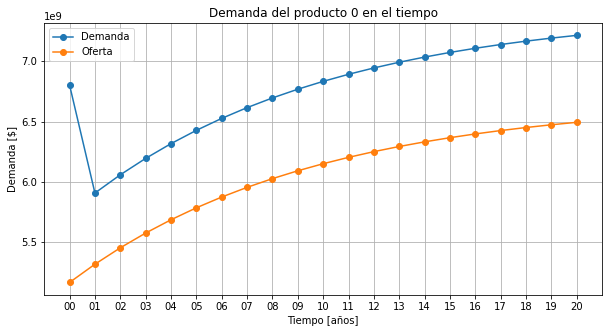

In [43]:
plot_product_demand(0)

In [46]:
def plot_country_export(country):
    df = supply_country(country)
    xs = df[TIME_COL]

    plt.figure(figsize=(10,5))
    product_exports = [[] for _ in df[VALUE_COL].iloc[0]]
    for t in df[VALUE_COL]:
        for i, val in enumerate(t):
            product_exports[i].append(val)
    for i, exports in enumerate(product_exports):
        plt.plot(xs, exports, marker='o')
    plt.grid(True)
    # plt.legend()
    plt.xlabel('Tiempo [años]')
    plt.ylabel('Exportaciones [$]')
    plt.title(f'Exportación del pais {countries_iso[country]}')

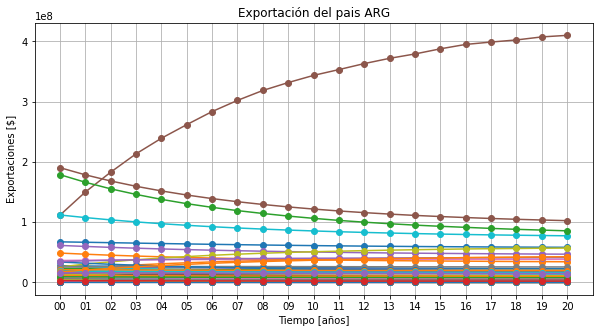

In [47]:
plot_country_export(81)

In [ ]:
def plot_gdp(country):
    df = salida[[f'gdp_c{country}' == port for port in salida[PORT_COL]]]
    xs = df[TIME_COL]
    ys = df[VALUE_COL]

    plt.figure(figsize=(10,5))
    plt.plot(xs, ys, marker='o')
    plt.grid(True)
    plt.xlabel('Tiempo [años]')
    plt.ylabel('Demanda [$]')
    plt.title(f'PBI del pais {country} en el tiempo')

In [ ]:
plot_gdp(0)